In [14]:
import tables
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
import matplotlib.pyplot as plt
from ctapipe.image import tailcuts_clean
from scipy.interpolate import griddata
from astropy import units as u
import numpy as np

In [15]:
data_path = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1/gamma_20deg_0deg_srun800-4169___cta-prod3_desert-2150m-Paranal-HB9.h5'
#data_path = '/Users/nicolamarinello/Downloads/gamma_20deg_0deg_srun800-4169___cta-prod3_desert-2150m-Paranal-HB9.h5'
data = tables.open_file(data_path)

# acquire the data
data_ainfo = data.root.Array_Info
data_einfo = data.root.Event_Info
data_LST = data.root.LST

print(repr(data_ainfo))
print(repr(data_einfo))
print(repr(data_LST))

# array info data
ai_run_array_direction = [x['run_array_direction']
                          for x in data_ainfo.iterrows()]
ai_tel_id = [x['tel_id'] for x in data_ainfo.iterrows()]
ai_tel_type = [x['tel_type'] for x in data_ainfo.iterrows()]
ai_tel_x = [x['tel_x'] for x in data_ainfo.iterrows()]
ai_tel_y = [x['tel_y'] for x in data_ainfo.iterrows()]
ai_tel_z = [x['tel_z'] for x in data_ainfo.iterrows()]

# event info data
ei_alt = [x['alt'] for x in data_einfo.iterrows()]
ei_az = [x['az'] for x in data_einfo.iterrows()]
ei_core_x = [x['core_x'] for x in data_einfo.iterrows()]
ei_core_y = [x['core_y'] for x in data_einfo.iterrows()]
ei_event_number = [x['event_number'] for x in data_einfo.iterrows()]
ei_h_first_int = [x['h_first_int'] for x in data_einfo.iterrows()]
ei_mc_energy = [x['mc_energy'] for x in data_einfo.iterrows()]
ei_particle_id = [x['particle_id'] for x in data_einfo.iterrows()]
ei_run_number = [x['run_number'] for x in data_einfo.iterrows()]
ei_LST_indices = [x['LST_indices'] for x in data_einfo.iterrows()]

# LST data
LST_event_index = [x['event_index'] for x in data_LST.iterrows()]
LST_image_charge = [x['image_charge'] for x in data_LST.iterrows()]
LST_image_peak_times = [x['image_peak_times'] for x in data_LST.iterrows()]

/Array_Info (Table(289,)) 'Table of array data'
  description := {
  "run_array_direction": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "tel_id": UInt8Col(shape=(), dflt=0, pos=1),
  "tel_type": StringCol(itemsize=8, shape=(), dflt=b'', pos=2),
  "tel_x": Float32Col(shape=(), dflt=0.0, pos=3),
  "tel_y": Float32Col(shape=(), dflt=0.0, pos=4),
  "tel_z": Float32Col(shape=(), dflt=0.0, pos=5)}
  byteorder := 'little'
  chunkshape := (2259,)
/Event_Info (Table(4853,)) 'Table of Events'
  description := {
  "alt": Float32Col(shape=(), dflt=0.0, pos=0),
  "az": Float32Col(shape=(), dflt=0.0, pos=1),
  "core_x": Float32Col(shape=(), dflt=0.0, pos=2),
  "core_y": Float32Col(shape=(), dflt=0.0, pos=3),
  "event_number": UInt32Col(shape=(), dflt=0, pos=4),
  "h_first_int": Float32Col(shape=(), dflt=0.0, pos=5),
  "mc_energy": Float32Col(shape=(), dflt=0.0, pos=6),
  "particle_id": UInt8Col(shape=(), dflt=0, pos=7),
  "run_number": UInt32Col(shape=(), dflt=0, pos=8),
  "LST_indices": Int32Col(sha

In [16]:
#e_idx = 58 , 674
e_idx = 2229
# select a spcific event
my_event = data_einfo[e_idx]
print('Event number: {}'.format(my_event['event_number']))
print('Energy: {} TeV'.format(my_event['mc_energy']))
print('Alt: {} rad'.format(my_event['alt']))
print('Az: {} rad'.format(my_event['az']))
my_indices = my_event['LST_indices']
print('LST_indices: ' + str(my_indices))

Event number: 375601
Energy: 0.9098318815231323 TeV
Alt: 1.2217304706573486 rad
Az: 6.283185005187988 rad
LST_indices: [2869 2870 2871 2872]


In [17]:
#we will take always the first lst index just for demostrations
# print event information
img_charge = LST_image_charge[my_indices[0]]
img_time = LST_image_peak_times[my_indices[0]]
print(img_charge)
print(img_time)

[-2.4409199  -0.7888425  -1.6547577  ... -1.2159475   2.3322046
 -0.56620854]
[16. 27.  0. ... 25. 26. 24.]


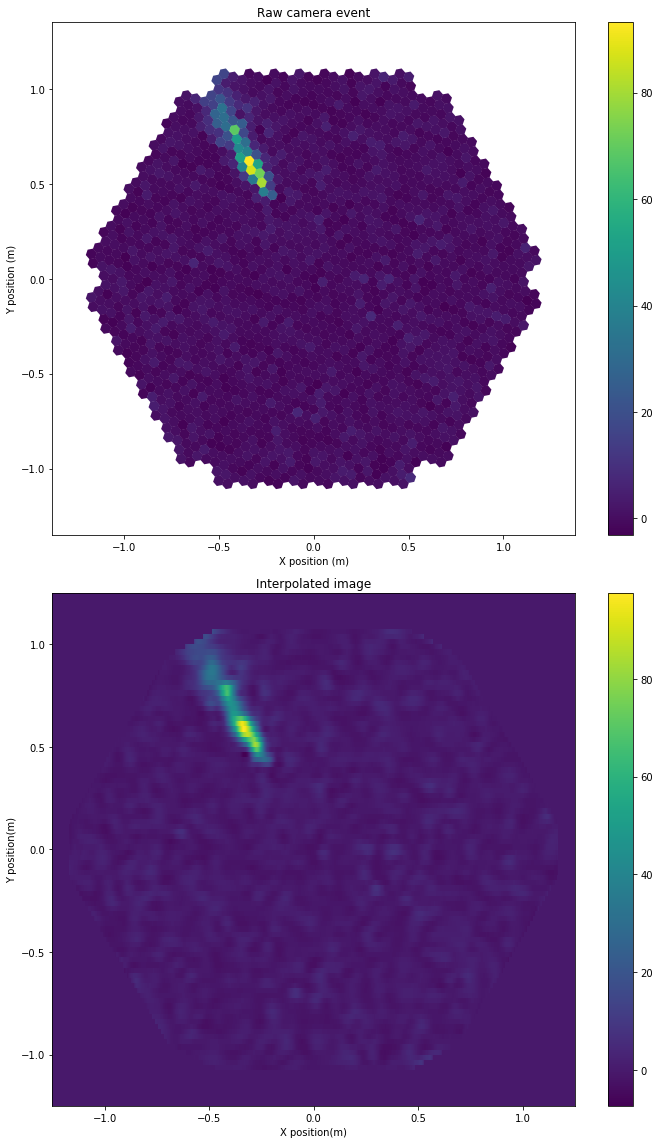

In [18]:
# Load the camera
%matplotlib inline 
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(10, 16))

# plt.suptitle('EVENT')
disps = []

ax = plt.subplot(2, 1, 1)

disp = CameraDisplay(geom, ax=ax, title="Raw camera event")
disp.add_colorbar()

# Apply image cleaning
cleanmask = tailcuts_clean(
    geom, img_charge, picture_thresh=10, boundary_thresh=5
)
clean = img_charge.copy()
clean[~cleanmask] = 0.0

# Show the camera image and overlay Hillas ellipse and clean
# pixels
disp.image = img_charge
# disp.cmap = 'inferno'
# disp.highlight_pixels(cleanmask, color='crimson')
disps.append(disp)

# interpolation

points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_charge)

grid_x, grid_y = np.mgrid[-1.25:1.25:1000j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

grid_z = np.nan_to_num(grid_z)

ax = plt.subplot(2, 1, 2)
ax.set_title('Interpolated image')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inferno = plt.get_cmap('inferno')
#inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', cmap=inferno)
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', aspect="auto")
plt.colorbar(inter, ax=ax)
plt.tight_layout()
#plt.savefig('real-interp.eps', format='eps', bbox_inches='tight', pad_inches=0.9)

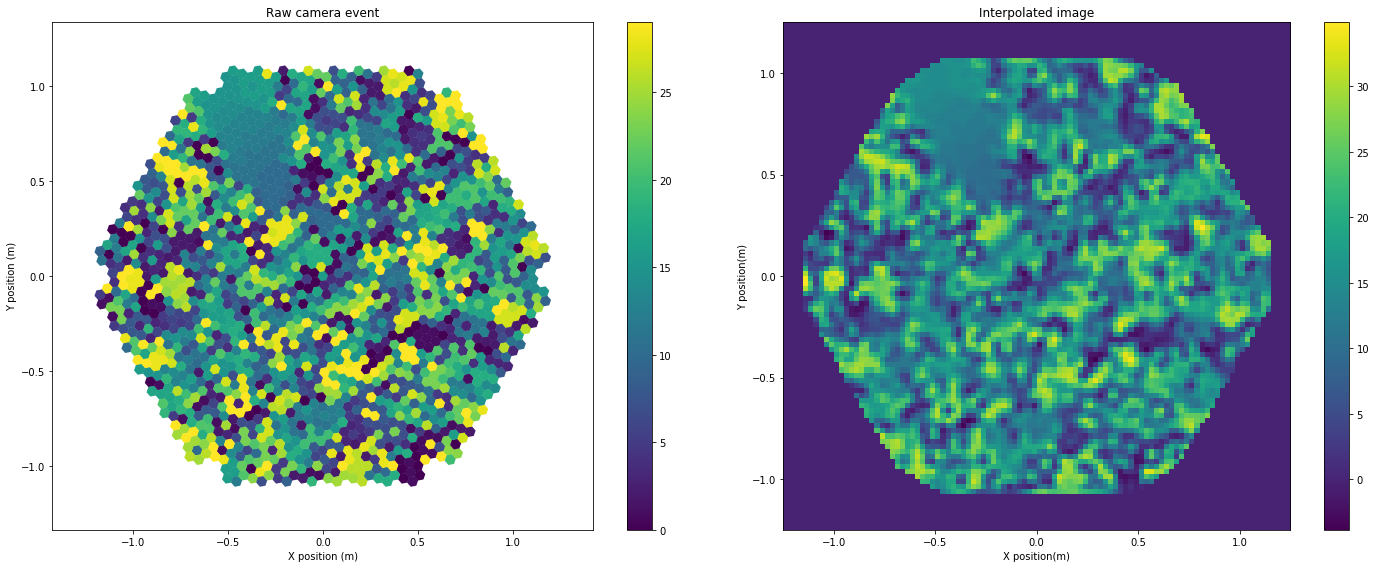

In [26]:
# Load the camera
%matplotlib inline 
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(20, 8))

#plt.suptitle('EVENT')
disps = []

ax = plt.subplot(1, 2, 1)

disp = CameraDisplay(geom, ax=ax, title="Raw camera event")
disp.add_colorbar()

# Apply image cleaning
cleanmask = tailcuts_clean(
    geom, img_time, picture_thresh=10, boundary_thresh=5
)
clean = img_time.copy()
clean[~cleanmask] = 0.0

# Show the camera image and overlay Hillas ellipse and clean
# pixels
disp.image = img_time
# disp.cmap = 'inferno'
# disp.highlight_pixels(cleanmask, color='crimson')
disps.append(disp)

# interpolation

points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_time)

#grid_x, grid_y = np.mgrid[-1.17:1.17:100j, -1.17:1.17:100j]
grid_x, grid_y = np.mgrid[-1.25:1.25:100j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

grid_z = np.nan_to_num(grid_z)

ax = plt.subplot(1, 2, 2)
ax.set_title('Interpolated image')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inferno = plt.get_cmap('inferno')
#inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', cmap=inferno)
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', aspect="equal")
plt.colorbar(inter, ax=ax)
plt.tight_layout()
plt.savefig('real-interp-time.eps', format='eps', bbox_inches='tight', pad_inches=0.9)

In [20]:
print(100*100 - np.count_nonzero(grid_z))

3750


In [21]:
print(grid_z[99][:])
print(grid_z.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
(100, 100)


{'intensity': 1408.6658382415771,
 'kurtosis': 2.066354351975025,
 'length': <Quantity 0.17381068 m>,
 'phi': <Angle 2.06827824 rad>,
 'psi': <Angle -1.09110863 rad>,
 'r': <Quantity 0.79771159 m>,
 'skewness': -0.28098394031337515,
 'width': <Quantity 0.04199072 m>,
 'x': <Quantity -0.38067929 m>,
 'y': <Quantity 0.70101859 m>}


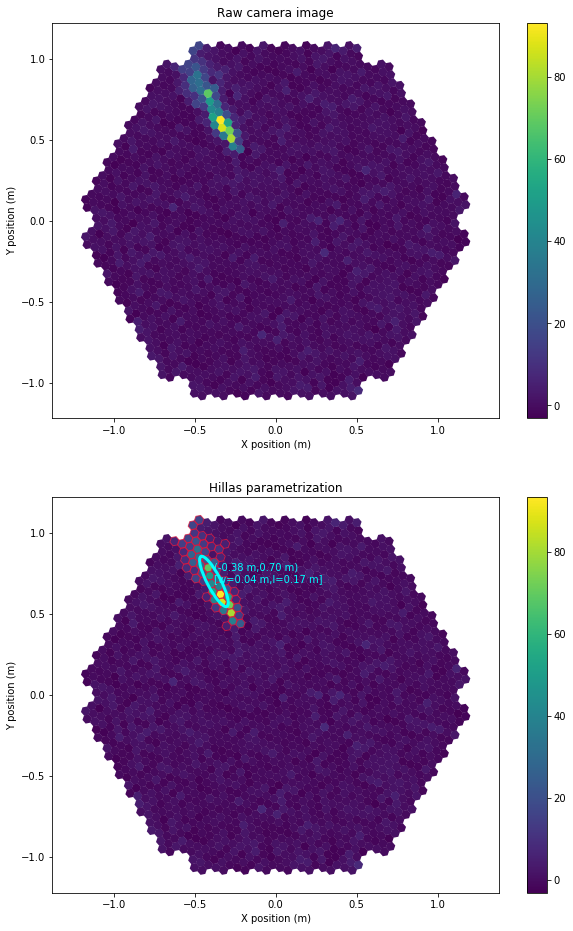

In [22]:
# hillas parameters

from ctapipe.image import toymodel, hillas_parameters, tailcuts_clean
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

# Load the camera
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(10, 16))

ax = plt.subplot(2, 1, 1)

disp = CameraDisplay(geom, ax=ax, title="Raw camera image")
disp.add_colorbar()

# Create a fake camera image to display:
# model = toymodel.generate_2d_shower_model(
#    centroid=(0.2, 0.0), width=0.05, length=0.15, psi='35d'
# )

#image, sig, bg = toymodel.make_toymodel_shower_image(
#    geom, model.pdf, intensity=1500, nsb_level_pe=3
#)

# Apply image cleaning
# cleanmask = tailcuts_clean(
#    geom, img_charge, picture_thresh=10, boundary_thresh=5
#)

# Calculate image parameters
#hillas = hillas_parameters(geom[cleanmask], img_charge[cleanmask])

# Show the camera image and overlay Hillas ellipse and clean pixels
disp.image = img_charge
#disp.highlight_pixels(cleanmask, color='crimson')
#disp.overlay_moments(hillas, color='cyan', linewidth=3)

# Load the camera
geom = CameraGeometry.from_name("LSTCam")

ax = plt.subplot(2, 1, 2)

disp = CameraDisplay(geom, ax=ax, title="Hillas parametrization")
disp.add_colorbar()

# Create a fake camera image to display:
# model = toymodel.generate_2d_shower_model(
#    centroid=(0.2, 0.0), width=0.05, length=0.15, psi='35d'
# )

#image, sig, bg = toymodel.make_toymodel_shower_image(
#    geom, model.pdf, intensity=1500, nsb_level_pe=3
#)

# Apply image cleaning
cleanmask = tailcuts_clean(
    geom, img_charge, picture_thresh=10, boundary_thresh=5
)

# Calculate image parameters
hillas = hillas_parameters(geom[cleanmask], img_charge[cleanmask])

# Show the camera image and overlay Hillas ellipse and clean pixels
disp.image = img_charge
disp.highlight_pixels(cleanmask, color='crimson')
disp.overlay_moments(hillas, color='cyan', linewidth=3)

print(hillas)

# plt.show()

# plt.savefig('raw_hilas.eps', format='eps', bbox_inches='tight', pad_inches=0.9)

2356
117
474
Energy: 1.5281083583831787 TeV
Energy: 93.2811050415039 TeV
Energy: 106.3115463256836 TeV
[3031 3032 3033 3034]
[32 33 34 35]
[198   0   0 199]


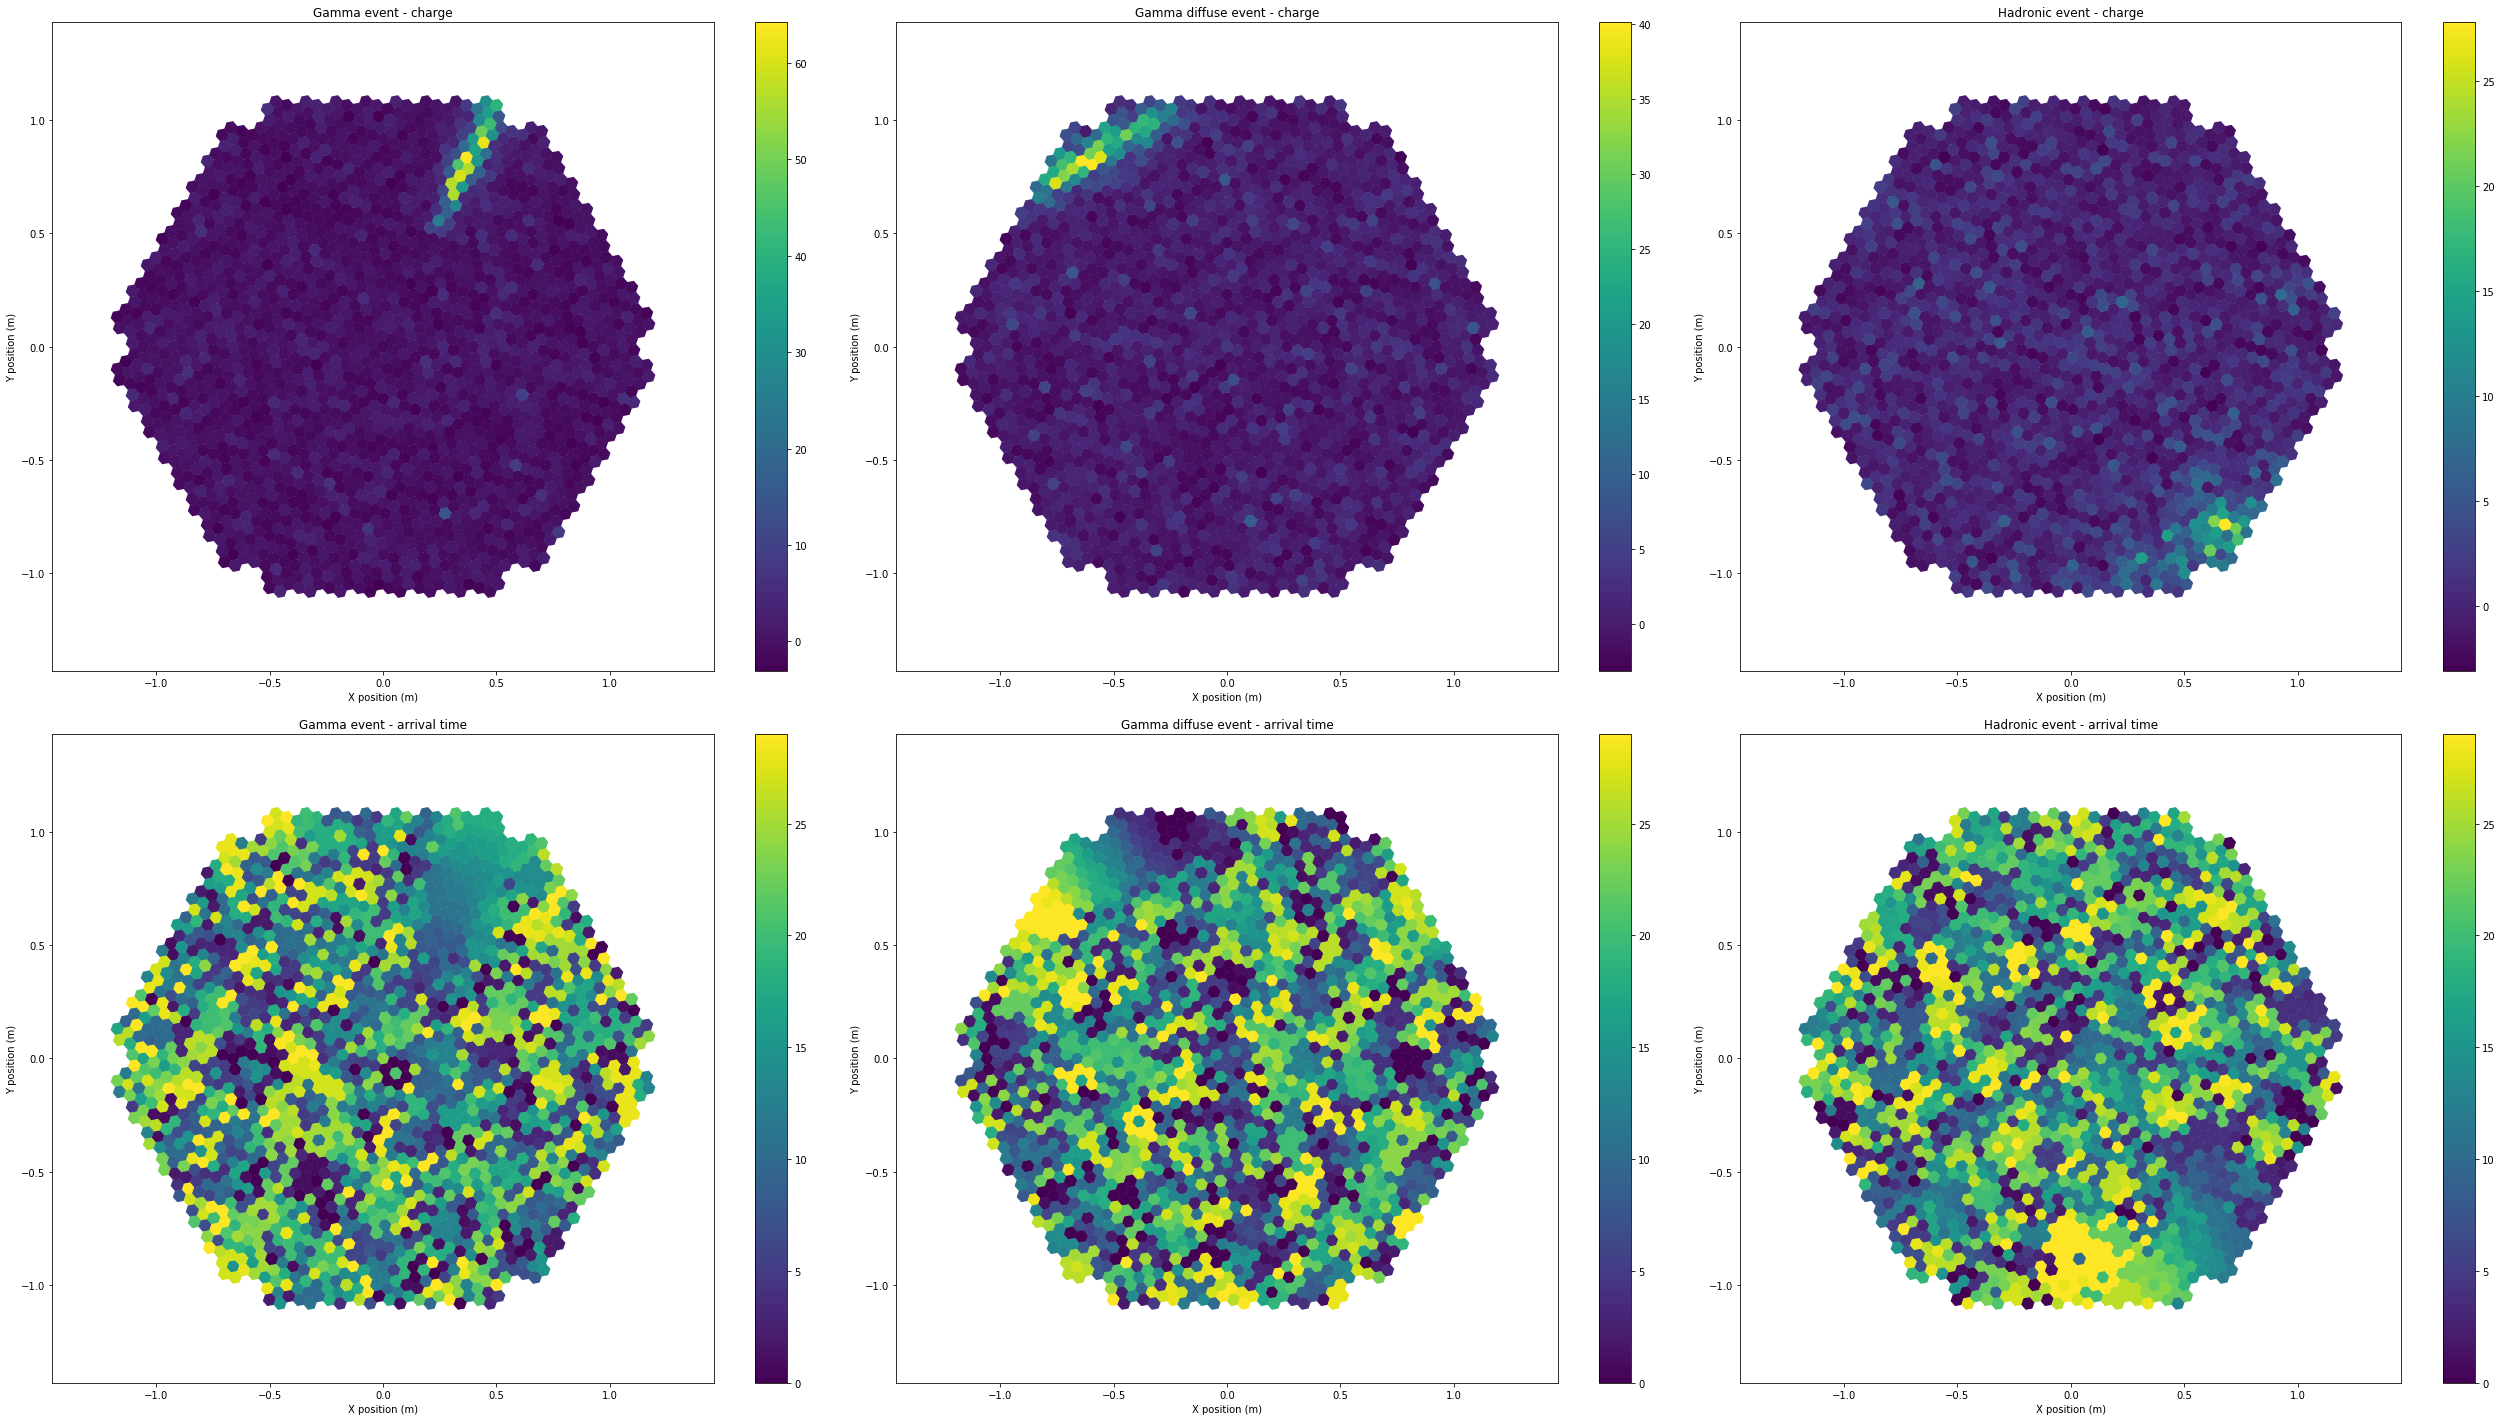

In [23]:
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
import numpy as np
import matplotlib

data_path_gamma = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1/gamma_20deg_0deg_srun800-4169___cta-prod3_desert-2150m-Paranal-HB9.h5'
data_path_gamdi = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_gamma-diffuse_North_20deg_3HB9_DL1_ML1/gamma_20deg_0deg_srun1000-5606___cta-prod3_desert-2150m-Paranal-HB9_cone10.h5'
data_path_proto = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_proton_North_20deg_3HB9_DL1_ML1/proton_20deg_0deg_srun971-3870___cta-prod3_desert-2150m-Paranal-HB9.h5'

data_gamma = tables.open_file(data_path_gamma)
data_gamdi = tables.open_file(data_path_gamdi)
data_proto = tables.open_file(data_path_proto)

# acquire the data
data_LST_gamma = data_gamma.root.LST
data_LST_gamdi = data_gamdi.root.LST
data_LST_proto = data_proto.root.LST
data_einfo_gamma = data_gamma.root.Event_Info
data_einfo_gamdi = data_gamdi.root.Event_Info
data_einfo_proto = data_proto.root.Event_Info

# LST data
LST_event_index_gamma = [x['event_index'] for x in data_LST_gamma.iterrows()]
LST_image_charge_gamma = [x['image_charge'] for x in data_LST_gamma.iterrows()]
LST_image_peak_times_gamma = [x['image_peak_times'] for x in data_LST_gamma.iterrows()]
ei_mc_energy_gamma = [x['mc_energy'] for x in data_einfo_gamma.iterrows()]

LST_event_index_gamdi = [x['event_index'] for x in data_LST_gamdi.iterrows()]
LST_image_charge_gamdi = [x['image_charge'] for x in data_LST_gamdi.iterrows()]
LST_image_peak_times_gamdi = [x['image_peak_times'] for x in data_LST_gamdi.iterrows()]
ei_mc_energy_gamdi = [x['mc_energy'] for x in data_einfo_gamdi.iterrows()]

LST_event_index_proto = [x['event_index'] for x in data_LST_proto.iterrows()]
LST_image_charge_proto = [x['image_charge'] for x in data_LST_proto.iterrows()]
LST_image_peak_times_proto = [x['image_peak_times'] for x in data_LST_proto.iterrows()]
ei_mc_energy_proto = [x['mc_energy'] for x in data_einfo_proto.iterrows()]

#e_idx_gamma = 3135
#e_idx_gamdi = 153
#e_idx_proto = 753

e_idx_gamma = np.argsort(-np.array(ei_mc_energy_gamma), axis=0)[553]
e_idx_gamdi = np.argsort(-np.array(ei_mc_energy_gamdi), axis=0)[10]
e_idx_proto = np.argsort(-np.array(ei_mc_energy_proto), axis=0)[64]
print(e_idx_gamma)
print(e_idx_gamdi)
print(e_idx_proto)

my_event_gamma = data_einfo_gamma[e_idx_gamma]
my_event_gamdi = data_einfo_gamdi[e_idx_gamdi]
my_event_proto = data_einfo_proto[e_idx_proto]

print('Energy: {} TeV'.format(my_event_gamma['mc_energy']))
print('Energy: {} TeV'.format(my_event_gamdi['mc_energy']))
print('Energy: {} TeV'.format(my_event_proto['mc_energy']))

my_indices_gamma = my_event_gamma['LST_indices']
my_indices_gamdi = my_event_gamdi['LST_indices']
my_indices_proto = my_event_proto['LST_indices']
print(my_indices_gamma)
print(my_indices_gamdi)
print(my_indices_proto)

img_charge_gamma = LST_image_charge_gamma[my_indices_gamma[0]]
img_time_gamma = LST_image_peak_times_gamma[my_indices_gamma[0]]

img_charge_gamdi = LST_image_charge_gamdi[my_indices_gamdi[0]]
img_time_gamdi = LST_image_peak_times_gamdi[my_indices_gamdi[0]]

img_charge_proto = LST_image_charge_proto[my_indices_proto[0]]
img_time_proto = LST_image_peak_times_proto[my_indices_proto[0]]

# Load the camera
geom = CameraGeometry.from_name("LSTCam")
f = 2
fig = plt.figure(figsize=(18*f, 10*f))

ax = plt.subplot(2, 3, 1)
disp = CameraDisplay(geom, ax=ax, title="Gamma event - charge")
disp.add_colorbar()
disp.image = img_charge_gamma

ax = plt.subplot(2, 3, 2)
disp = CameraDisplay(geom, ax=ax, title="Gamma diffuse event - charge")
disp.add_colorbar()
disp.image = img_charge_gamdi

ax = plt.subplot(2, 3, 3)
disp = CameraDisplay(geom, ax=ax, title="Hadronic event - charge")
disp.add_colorbar()
disp.image = img_charge_proto

ax = plt.subplot(2, 3, 4)
disp = CameraDisplay(geom, ax=ax, title="Gamma event - arrival time")
disp.add_colorbar()
disp.image = img_time_gamma

ax = plt.subplot(2, 3, 5)
disp = CameraDisplay(geom, ax=ax, title="Gamma diffuse event - arrival time")
disp.add_colorbar()
disp.image = img_time_gamdi

ax = plt.subplot(2, 3, 6)
disp = CameraDisplay(geom, ax=ax, title="Hadronic event - arrival time")
disp.add_colorbar()
disp.image = img_time_proto

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

plt.tight_layout()
plt.savefig('dataset_example.eps', format='eps', bbox_inches='tight', pad_inches=0)

In [24]:
# execute on VM with ipython
from keras.utils.data_utils import OrderedEnqueuer
from keras.utils.generic_utils import Progbar

from generators import DataGeneratorR
from utils import get_all_files
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

def retrieve_energy(generator):
    # retrieve energy
    print('Retrieving ground truth...')
    gt_feature = []
    steps_done = 0
    steps = len(generator)

    enqueuer = OrderedEnqueuer(generator, use_multiprocessing=True)
    enqueuer.start(workers=24, max_queue_size=10)
    output_generator = enqueuer.get()

    progbar = Progbar(target=steps)

    while steps_done < steps:
        generator_output = next(output_generator)
        _, y = generator_output
        gt_feature.append(y)
        # print('steps_done', steps_done)
        # print(y)
        steps_done += 1
        progbar.update(steps_done)
        
    return np.array(gt_feature)
        

data_path_gamma = ['/mnt/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1_interp/']
data_path_gamdi = ['/mnt/simulations/Paranal_gamma-diffuse_North_20deg_3HB9_DL1_ML1_interp/']
data_path_proto = ['/mnt/simulations/Paranal_proton_North_20deg_3HB9_DL1_ML1_interp/']

h5files_gamma = get_all_files(data_path_gamma)
h5files_gamdi = get_all_files(data_path_gamdi)
h5files_proto = get_all_files(data_path_proto)

print('Building test generator...')
generator_gamma = DataGeneratorR(h5files_gamma, feature='energy', batch_size=64, arrival_time=False, shuffle=False)
generator_gamdi = DataGeneratorR(h5files_gamdi, feature='energy', batch_size=64, arrival_time=False, shuffle=False)
generator_proto = DataGeneratorR(h5files_proto, feature='energy', batch_size=64, arrival_time=False, shuffle=False)

ei_mc_energy_gamma = retrieve_energy(generator_gamma)
ei_mc_energy_gamdi = retrieve_energy(generator_gamdi)
ei_mc_energy_proto = retrieve_energy(generator_proto)

ei_mc_energy_gamma = np.array(ei_mc_energy_gamma).reshape(64*len(generator_gamma))
ei_mc_energy_gamdi = np.array(ei_mc_energy_gamdi).reshape(64*len(generator_gamdi))
ei_mc_energy_proto = np.array(ei_mc_energy_proto).reshape(64*len(generator_proto))

f = 1
fig = plt.figure(figsize=(18*f, 5*f))

bins = 50

ax = plt.subplot(1, 3, 1)
plt.hist(ei_mc_energy_gamma, bins)
plt.yscale('log', nonposy='clip')
plt.xlabel('$log_{10}E_{event}[TeV]$')
plt.ylabel('# of events [Log]')
plt.title('Gamma energy distribution')

ax = plt.subplot(1, 3, 2)
plt.hist(ei_mc_energy_gamdi, bins)
plt.yscale('log', nonposy='clip')
plt.xlabel('$log_{10}E_{event}[TeV]$')
plt.ylabel('# of events [Log]')
plt.title('Gamma-diffuse energy distribution')

ax = plt.subplot(1, 3, 3)
plt.hist(ei_mc_energy_proto, bins)
plt.yscale('log', nonposy='clip')
plt.xlabel('$log_{10}E_{event}[TeV]$')
plt.ylabel('# of events [Log]')
plt.title('Protons energy distribution')

#plt.suptitle('Dataset energy distribution')

plt.tight_layout()
#plt.savefig('dataset_distrib.eps', format='eps', bbox_inches='tight', pad_inches=0)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1_interp/'